In [1]:
import time
import torch.backends.cudnn as cudnn
from torch import nn
from models import Generator, Discriminator, TruncatedVGG19
from datasets import SRDataset
from dataset import LowDataset
from utils import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data parameters
data_folder = 'data'
crop_size = 96  # crop size of target HR images
scaling_factor = 2  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Generator parameters
large_kernel_size_g = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size_g = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels_g = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks_g = 16  # number of residual blocks
srresnet_checkpoint = "checkpoint_srresnet60k_e54_96r2.pth.tar"#"checkpoint_srresnet.pth.tar"  # filepath of the trained SRResNet checkpoint used for initialization

# Discriminator parameters
kernel_size_d = 3  # kernel size in all convolutional blocks
n_channels_d = 64  # number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
n_blocks_d = 8  # number of convolutional blocks
fc_size_d = 1024  # size of the first fully connected layer

# Learning parameters
checkpoint = None#'checkpoint_srgan.pth.tar'  # path to model (SRGAN) checkpoint, None if none
batch_size = 32 # batch size
start_epoch = 0  # start at this epoch
iterations = 2e5  # number of training iterations
workers = 4  # number of workers for loading data in the DataLoader
vgg19_i = 5  # the index i in the definition for VGG loss; see paper or models.py
vgg19_j = 4  # the index j in the definition for VGG loss; see paper or models.py
beta = 1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
print_freq = 100  # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True
print(device)

cuda


In [3]:
def train(train_loader, val_loader, generator, discriminator, truncated_vgg19, content_loss_criterion, adversarial_loss_criterion,
          optimizer_g, optimizer_d, epoch, trloz_c, trloz_a, trloz_d):
    """
    One epoch's training.
    :param train_loader: train dataloader
    :param generator: generator
    :param discriminator: discriminator
    :param truncated_vgg19: truncated VGG19 network
    :param content_loss_criterion: content loss function (Mean Squared-Error loss)
    :param adversarial_loss_criterion: adversarial loss function (Binary Cross-Entropy loss)
    :param optimizer_g: optimizer for the generator
    :param optimizer_d: optimizer for the discriminator
    :param epoch: epoch number
    """
    # Set to train mode
    generator.train()
    discriminator.train()  # training mode enables batch normalization

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    tr_losses_c = AverageMeter()  # content loss
    tr_losses_a = AverageMeter()  # adversarial loss in the generator
    tr_losses_d = AverageMeter()  # adversarial loss in the discriminator
    val_losses_c = AverageMeter()  # content loss
    val_losses_a = AverageMeter()  # adversarial loss in the generator
    val_losses_d = AverageMeter()  # adversarial loss in the discriminator

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), imagenet-normed

        # GENERATOR UPDATE

        # Generate
        sr_imgs = generator(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
        #sr_imgs = convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')  # (N, 3, 96, 96), imagenet-normed

        # Calculate VGG feature maps for the super-resolved (SR) and high resolution (HR) images
        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()  # detached because they're constant, targets

        # Discriminate super-resolved (SR) images
        sr_discriminated = discriminator(sr_imgs)  # (N)

        # Calculate the Perceptual loss
        content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))
        perceptual_loss = content_loss + beta * adversarial_loss

        # Back-prop.
        optimizer_g.zero_grad()
        perceptual_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_g, grad_clip)

        # Update generator
        optimizer_g.step()

        # Keep track of loss
        tr_losses_c.update(content_loss.item(), lr_imgs.size(0))
        tr_losses_a.update(adversarial_loss.item(), lr_imgs.size(0))
        trloz_c.append(content_loss.item())
        trloz_a.append(adversarial_loss.item())

        # DISCRIMINATOR UPDATE

        # Discriminate super-resolution (SR) and high-resolution (HR) images
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())
        # But didn't we already discriminate the SR images earlier, before updating the generator (G)? Why not just use that here?
        # Because, if we used that, we'd be back-propagating (finding gradients) over the G too when backward() is called
        # It's actually faster to detach the SR images from the G and forward-prop again, than to back-prop. over the G unnecessarily
        # See FAQ section in the tutorial

        # Binary Cross-Entropy loss
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + \
                           adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))

        # Back-prop.
        optimizer_d.zero_grad()
        adversarial_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_d, grad_clip)

        # Update discriminator
        optimizer_d.step()

        # Keep track of loss
        tr_losses_d.update(adversarial_loss.item(), hr_imgs.size(0))
        trloz_d.append(adversarial_loss.item())

        # Keep track of batch times
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()
        
        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Cont. Loss {loss_c.val:.4f} ({loss_c.avg:.4f})----'
                  'Adv. Loss {loss_a.val:.4f} ({loss_a.avg:.4f})----'
                  'Disc. Loss {loss_d.val:.4f} ({loss_d.avg:.4f})'.format(epoch,
                                                                          i,
                                                                          len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time,
                                                                          loss_c=tr_losses_c,
                                                                          loss_a=tr_losses_a,
                                                                          loss_d=tr_losses_d))
            
    del lr_imgs, hr_imgs, sr_imgs, hr_imgs_in_vgg_space, sr_imgs_in_vgg_space, hr_discriminated, sr_discriminated  # free some memory since their histories may be store
    
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(val_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            sr_imgs = generator(lr_imgs)
            sr_imgs = convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')
            sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
            hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()
            sr_discriminated = discriminator(sr_imgs)

            content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
            adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))

            val_losses_c.update(content_loss.item(), lr_imgs.size(0))
            val_losses_a.update(adversarial_loss.item(), lr_imgs.size(0))

            hr_discriminated = discriminator(hr_imgs)
            sr_discriminated = discriminator(sr_imgs.detach())

            adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + \
                               adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))
            val_losses_d.update(adversarial_loss.item(), hr_imgs.size(0))
        print('Epoch: [{0}] ==='
              'Cont. Loss {loss_c.val:.4f} ({loss_c.avg:.4f})----'
              'Adv. Loss {loss_a.val:.4f} ({loss_a.avg:.4f})----'
              'Disc. Loss {loss_d.val:.4f} ({loss_d.avg:.4f})'.format(epoch,
                                                                      loss_c=val_losses_c,
                                                                      loss_a=val_losses_a,
                                                                      loss_d=val_losses_d))

        del lr_imgs, hr_imgs, sr_imgs, hr_imgs_in_vgg_space, sr_imgs_in_vgg_space, hr_discriminated, sr_discriminated  # free some memory since their histories may be store
    return trloz_c, trloz_a, trloz_d

In [4]:
def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint, srresnet_checkpoint

    # Initialize model or load checkpoint
    if checkpoint is None:
        # Generator
        generator = Generator(large_kernel_size=large_kernel_size_g,
                              small_kernel_size=small_kernel_size_g,
                              n_channels=n_channels_g,
                              n_blocks=n_blocks_g,
                              scaling_factor=scaling_factor)

        # Initialize generator network with pretrained SRResNet
        if srresnet_checkpoint is not None:
            generator.initialize_with_srresnet(srresnet_checkpoint=srresnet_checkpoint)

        # Initialize generator's optimizer
        optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),
                                       lr=lr)

        # Discriminator
        discriminator = Discriminator(kernel_size=kernel_size_d,
                                      n_channels=n_channels_d,
                                      n_blocks=n_blocks_d,
                                      fc_size=fc_size_d)

        # Initialize discriminator's optimizer
        optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),
                                       lr=lr)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        generator = checkpoint['generator']
        discriminator = checkpoint['discriminator']
        optimizer_g = checkpoint['optimizer_g']
        optimizer_d = checkpoint['optimizer_d']
        print("\nLoaded checkpoint from epoch %d.\n" % (checkpoint['epoch'] + 1))

    # Truncated VGG19 network to be used in the loss calculation
    truncated_vgg19 = TruncatedVGG19(i=vgg19_i, j=vgg19_j)
    truncated_vgg19.eval()

    # Loss functions
    content_loss_criterion = nn.MSELoss()
    adversarial_loss_criterion = nn.BCEWithLogitsLoss()

    # Move to default device
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    truncated_vgg19 = truncated_vgg19.to(device)
    content_loss_criterion = content_loss_criterion.to(device)
    adversarial_loss_criterion = adversarial_loss_criterion.to(device)

    train_dataset = LowDataset('tr2', res_scale=scaling_factor, hr_dim=crop_size)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_dataset = LowDataset('v5', res_scale=scaling_factor, hr_dim=crop_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)

    trloz_c = []
    trloz_a = []
    trloz_d = []
    
    # Epochs
    for epoch in range(start_epoch, epochs):

        # At the halfway point, reduce learning rate to a tenth
        if epoch == int((iterations / 2) // len(train_loader) + 1):
            adjust_learning_rate(optimizer_g, 0.1)
            adjust_learning_rate(optimizer_d, 0.1)

        # One epoch's training
        trloz_c, trloz_a, trloz_d = train(train_loader=train_loader,
              val_loader=val_loader,
              generator=generator,
              discriminator=discriminator,
              truncated_vgg19=truncated_vgg19,
              content_loss_criterion=content_loss_criterion,
              adversarial_loss_criterion=adversarial_loss_criterion,
              optimizer_g=optimizer_g,
              optimizer_d=optimizer_d,
              epoch=epoch, trloz_c=trloz_c, trloz_a=trloz_a, trloz_d=trloz_d)
        
        N = len(trloz_a)
        x = np.linspace(0, N, N)

        plt.plot(x, trloz_c, "-b", label="content")
        plt.plot(x, trloz_a, "-r", label="adv")
        plt.plot(x, trloz_d, "-g", label="disc")
        plt.legend(loc="upper right")
        plt.show()

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'generator': generator,
                    'discriminator': discriminator,
                    'optimizer_g': optimizer_g,
                    'optimizer_d': optimizer_d},
                   'checkpoint_srgan.pth.tar')

In [ ]:
if __name__ == '__main__':
    main()

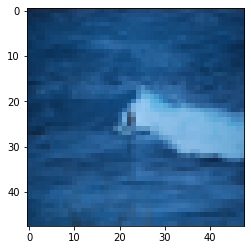

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


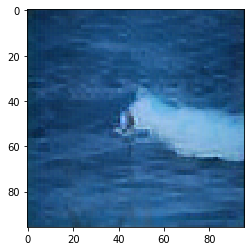

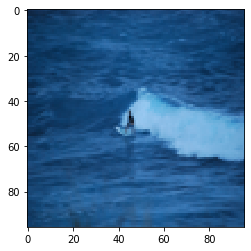

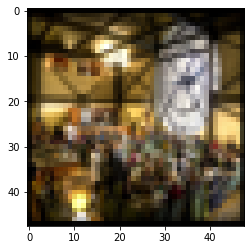

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


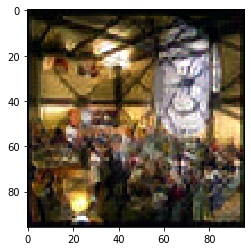

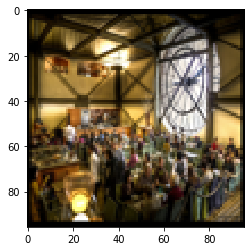

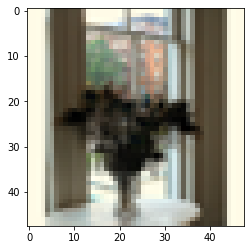

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


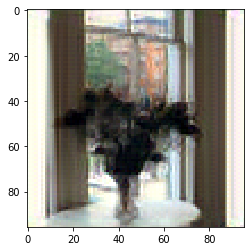

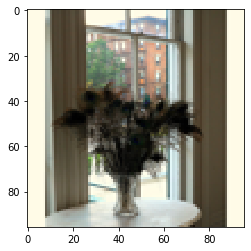

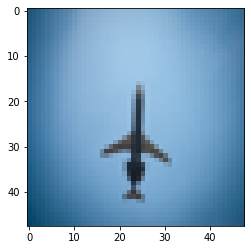

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


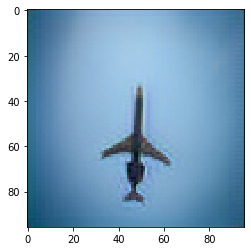

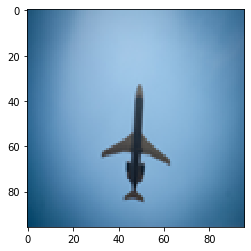

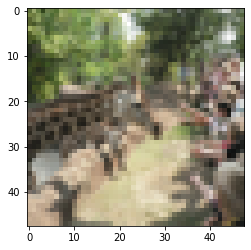

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


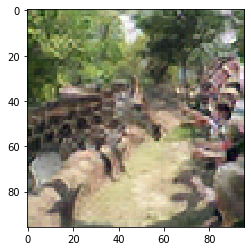

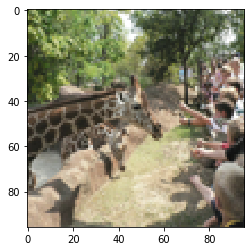

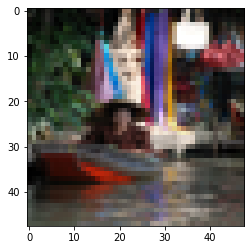

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


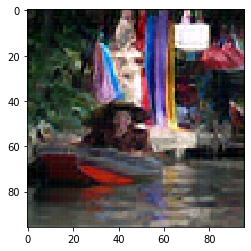

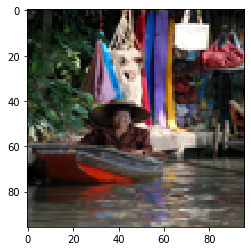

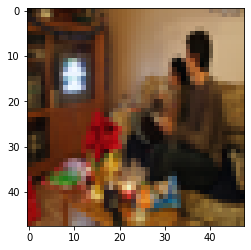

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


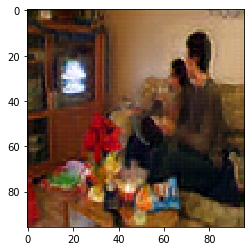

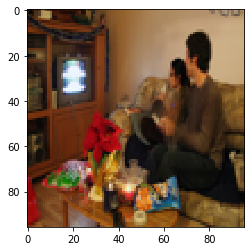

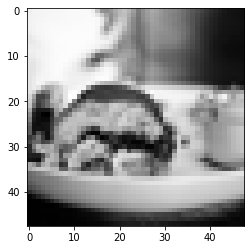

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


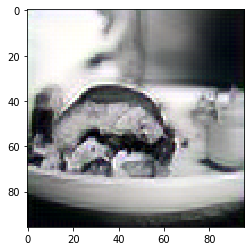

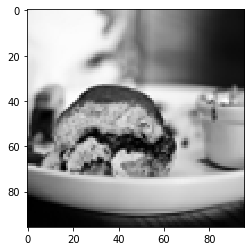

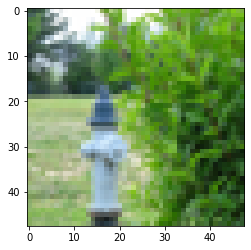

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


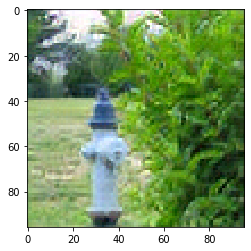

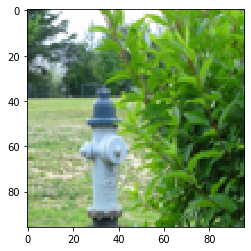

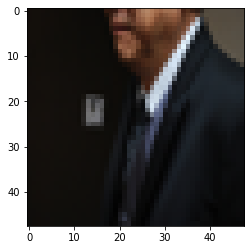

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


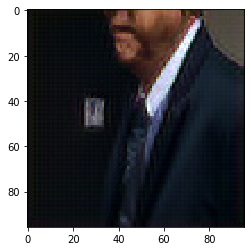

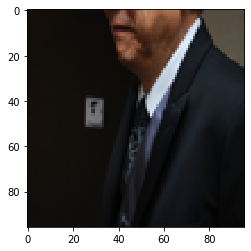

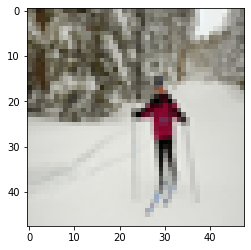

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


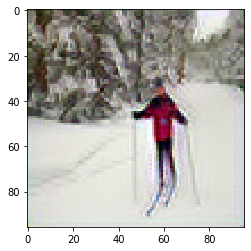

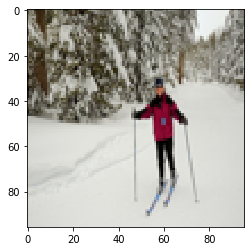

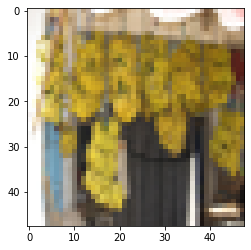

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


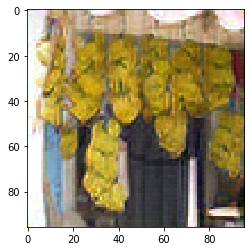

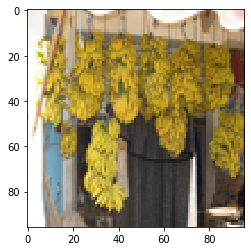

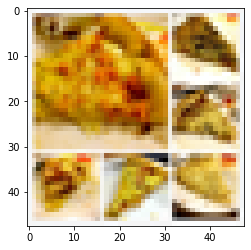

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


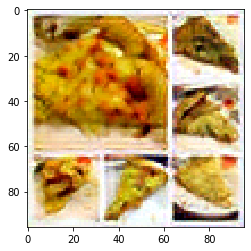

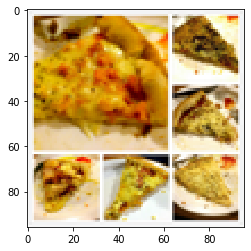

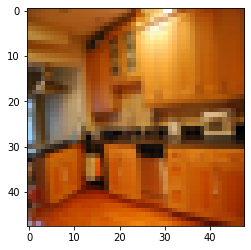

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


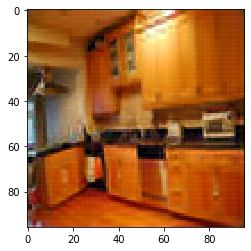

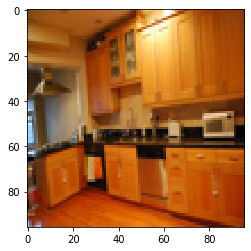

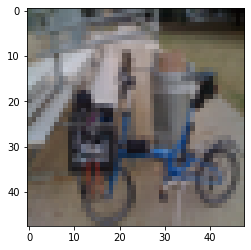

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


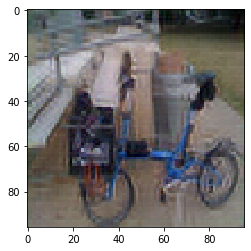

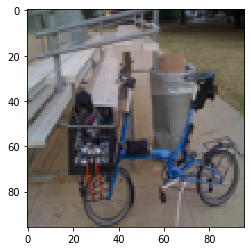

KeyboardInterrupt: 

In [9]:
checkpoint = torch.load('7checkpoint_srgan.pth.tar')
start_epoch = checkpoint['epoch'] + 1
generator = checkpoint['generator']
discriminator = checkpoint['discriminator']
optimizer_g = checkpoint['optimizer_g']
optimizer_d = checkpoint['optimizer_d']

generator = generator.to('cpu')
discriminator = discriminator.to('cpu')
valid_dataset = LowDataset('v5', res_scale=scaling_factor, hr_dim=crop_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=workers, pin_memory=True)

generator.eval()
discriminator.eval()
for i, (lr_imgs, hr_imgs) in enumerate(valid_loader):
    lr_imgs = lr_imgs.to('cpu')  # (batch_size (N), 3, 24, 24), imagenet-normed
    hr_imgs = hr_imgs.to('cpu')  # (batch_size (N), 3, 96, 96), in [-1, 1]

    sr_imgs = generator(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
    plt.imshow(lr_imgs[0].detach().permute(1, 2, 0))
    plt.show()
    plt.imshow(sr_imgs[0].detach().permute(1, 2, 0))
    plt.show()
    plt.imshow(hr_imgs[0].detach().permute(1, 2, 0))
    plt.show()